In [0]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

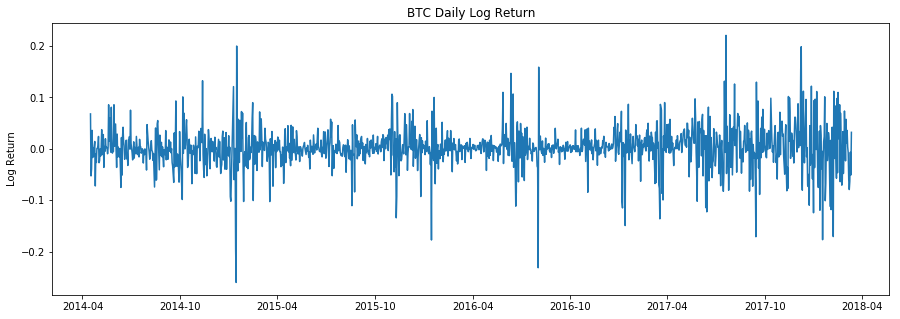

In [0]:
btc_df = quandl.get("BITSTAMP/USD", authtoken="HBdbdzczsM-uS6BNxroQ") #2014-04-15 to current

'''Using daily closing price of BTC to USD, calculate daily logarithmic returns
Saves percentage change from yesterday in column pct_change, and saves logarithmic
returns in column log_return'''

btc_df['pct_change'] = btc_df['Last'].pct_change()
btc_df['log_return'] = np.log(1 + btc_df['pct_change'])
btc_df.drop(btc_df.index[0], inplace=True) #drop first row because of n/a log_return value

log_return_btc_df = btc_df[["log_return"]]#save log_returns column to its own dataframe

plt.figure(figsize=(15,5))
plt.plot(btc_df.index,btc_df['log_return'])
plt.ylabel('Log Return')
plt.title('BTC Daily Log Return');

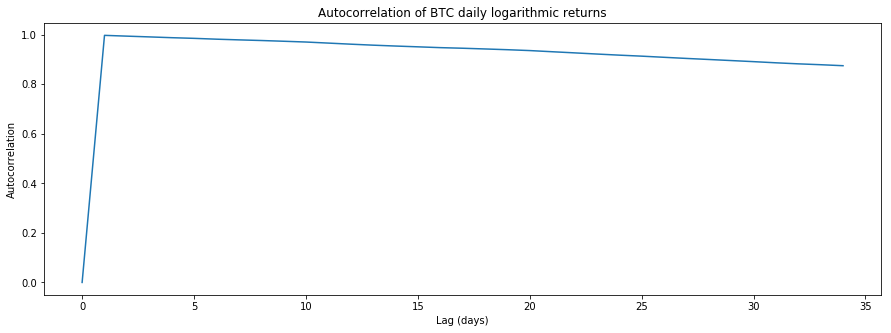

In [0]:
'''Autocorrelation of btc log returns:'''
log_return_btc = btc_df['Last']
auto_corr_btc_returns = np.zeros(shape=35)
#print("autocorrelation coefficients for BTC daily logarithmic returns:")
for N in range(1,35):
    auto_corr_btc_return = log_return_btc.autocorr(lag=N)
    auto_corr_btc_returns[N] = auto_corr_btc_return

plt.figure(figsize=(15,5))
plt.plot(auto_corr_btc_returns)
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (days)')
plt.title('Autocorrelation of BTC daily logarithmic returns');

C:\Users\Ilyas\Miniconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Ilyas\Miniconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\Ilyas\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Ilyas\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Ilyas\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                              ARMA Model Results                              
Dep. Variable:                   Last   No. Observations:                 1408
Model:                     ARMA(4, 1)   Log Likelihood               -9697.317
Method:                           css   S.D. of innovations            241.769
Date:                Tue, 13 Mar 2018   AIC                          19408.634
Time:                        09:50:19   BIC                          19445.364
Sample:                    04-20-2014   HQIC                         19422.362
                         - 03-12-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1880.1398        nan        nan        nan         nan         nan
ar.L1.Last     0.3574      0.059      6.095      0.000       0.242       0.472
ar.L2.Last     0.6691      0.064     10.439      0.0

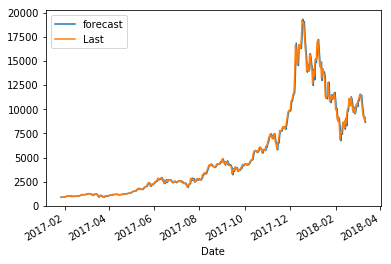

In [0]:
from statsmodels.tsa.arima_model import ARIMA

#http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html
#statsmodels.tsa.arima_model.ARIMA(endog, order, exog=None, dates=None, freq=None, missing='none')
arima_model = ARIMA(endog=btc_df['Last'], order=(4,0,1))
#ARIMA.fit(start_params=None, trend='c', method='css-mle', transparams=True, solver='lbfgs', maxiter=50, full_output=1, disp=5, callback=None, start_ar_lags=None, **kwargs)
arima_fit = arima_model.fit(method='css', transparams=True, disp=2, start_ar_lags=None)
print(arima_fit.summary())

fig = arima_fit.plot_predict(start=1000, plot_insample=True)

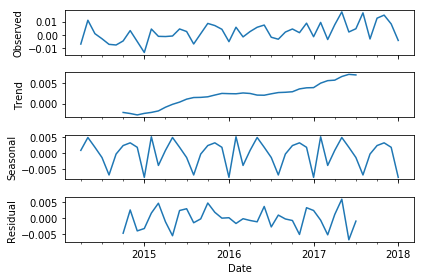

In [0]:
log_return_btc_df_month = log_return_btc_df.resample('M').mean()
log_return_btc_df_month
sm.tsa.seasonal_decompose(log_return_btc_df_month).plot()
plt.figure(figsize=(15,7))

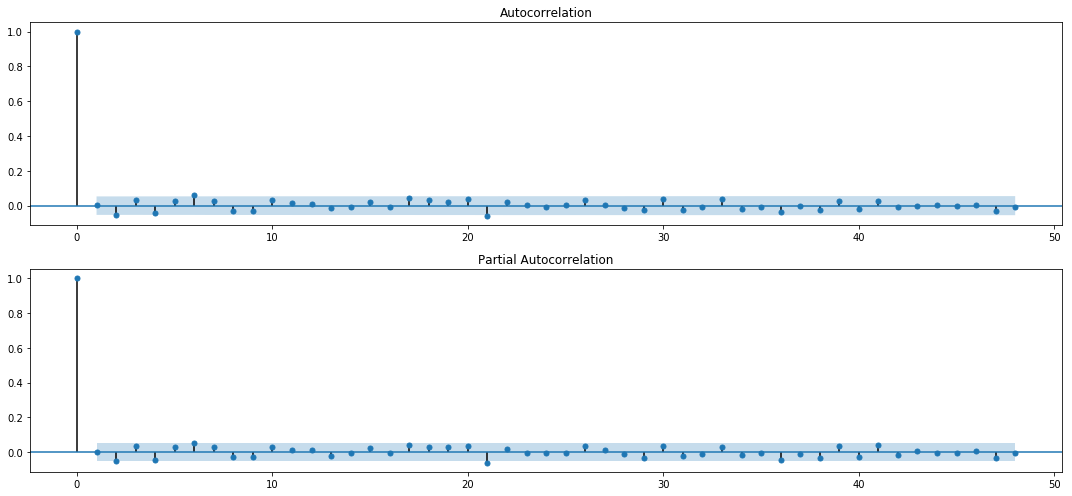

In [0]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(log_return_btc_df, lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(log_return_btc_df, lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [0]:
#https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima

from itertools import product
import warnings

Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D = 1
d = 1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list: 
    try:
        model=sm.tsa.statespace.SARIMAX(log_return_btc_df_month, order=(param[0], d, param[1]),
                                       seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong params:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong params: (0, 0, 0, 0)
wrong params: (0, 0, 0, 1)
wrong params: (0, 0, 1, 1)
wrong params: (0, 0, 2, 1)
wrong params: (0, 1, 0, 1)
wrong params: (0, 1, 1, 1)
wrong params: (0, 1, 2, 1)
wrong params: (0, 2, 0, 0)
wrong params: (0, 2, 0, 1)
wrong params: (0, 2, 1, 0)
wrong params: (0, 2, 1, 1)
wrong params: (0, 2, 2, 0)
wrong params: (0, 2, 2, 1)
wrong params: (1, 0, 0, 1)
wrong params: (1, 0, 1, 1)
wrong params: (1, 0, 2, 1)
wrong params: (1, 1, 0, 1)
wrong params: (1, 1, 1, 1)
wrong params: (1, 1, 2, 1)
wrong params: (1, 2, 0, 0)
wrong params: (1, 2, 0, 1)
wrong params: (1, 2, 1, 0)
wrong params: (1, 2, 1, 1)
wrong params: (1, 2, 2, 0)
wrong params: (1, 2, 2, 1)
wrong params: (2, 0, 0, 1)
wrong params: (2, 0, 1, 1)
wrong params: (2, 0, 2, 1)
wrong params: (2, 1, 0, 1)
wrong params: (2, 1, 1, 1)
wrong params: (2, 1, 2, 1)
wrong params: (2, 2, 0, 1)
wrong params: (2, 2, 1, 1)
wrong params: (2, 2, 2, 1)


In [0]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
11  (2, 0, 0, 0) -241.048235
12  (2, 0, 1, 0) -239.302916
14  (2, 1, 0, 0) -239.275629
15  (2, 1, 1, 0) -238.152281
17  (2, 2, 0, 0) -237.926407
                                 Statespace Model Results                                 
Dep. Variable:                         log_return   No. Observations:                   46
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 123.524
Date:                            Thu, 25 Jan 2018   AIC                           -241.048
Time:                                    13:43:14   BIC                           -235.562
Sample:                                04-30-2014   HQIC                          -238.993
                                     - 01-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

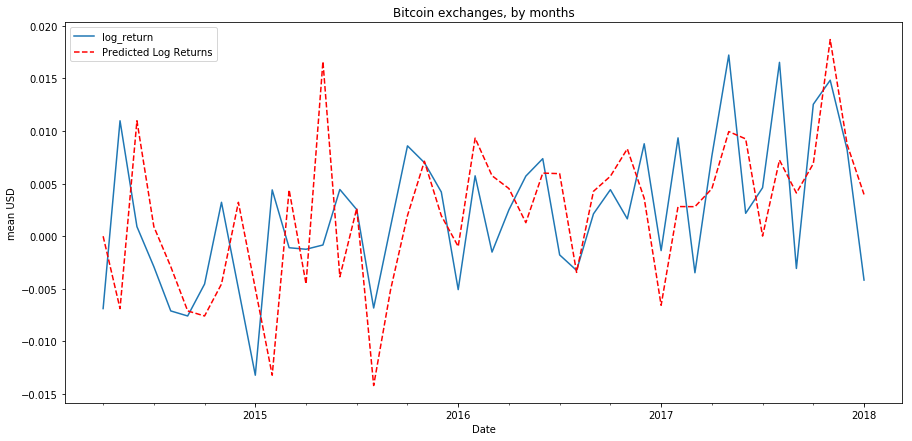

In [0]:
from datetime import datetime

log_return_btc_df_month['forecast'] = best_model.predict(start=0, end=46)
plt.figure(figsize=(15,7))
log_return_btc_df_month.log_return.plot()
log_return_btc_df_month.forecast.plot(color='r', ls='--', label='Predicted Log Returns')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()